<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Diffusion-Digits---Generating-MNIST-Digits-from-noise-with-HuggingFace-Diffusers" data-toc-modified-id="Diffusion-Digits---Generating-MNIST-Digits-from-noise-with-HuggingFace-Diffusers-1">Diffusion Digits - Generating MNIST Digits from noise with HuggingFace Diffusers</a></span><ul class="toc-item"><li><span><a href="#Diffusion-Models---Quick-and-Dirty" data-toc-modified-id="Diffusion-Models---Quick-and-Dirty-1.1">Diffusion Models - Quick and Dirty</a></span><ul class="toc-item"><li><span><a href="#Diffusion-Models---Training" data-toc-modified-id="Diffusion-Models---Training-1.1.1">Diffusion Models - Training</a></span></li><li><span><a href="#Diffusion-Models---Sampling" data-toc-modified-id="Diffusion-Models---Sampling-1.1.2">Diffusion Models - Sampling</a></span></li></ul></li><li><span><a href="#Outline" data-toc-modified-id="Outline-1.2">Outline</a></span></li><li><span><a href="#Defining-Hyperparameters" data-toc-modified-id="Defining-Hyperparameters-1.3">Defining Hyperparameters</a></span></li><li><span><a href="#Preparing-MNIST-Dataset" data-toc-modified-id="Preparing-MNIST-Dataset-1.4">Preparing MNIST Dataset</a></span><ul class="toc-item"><li><span><a href="#Downloading-MNIST-with-HuggingFace-datasets" data-toc-modified-id="Downloading-MNIST-with-HuggingFace-datasets-1.4.1">Downloading MNIST with HuggingFace <code>datasets</code></a></span></li><li><span><a href="#Data-Preprocessing-and-Augmentation" data-toc-modified-id="Data-Preprocessing-and-Augmentation-1.4.2">Data Preprocessing and Augmentation</a></span></li></ul></li><li><span><a href="#Creating-the-Diffusion-Model" data-toc-modified-id="Creating-the-Diffusion-Model-1.5">Creating the Diffusion Model</a></span><ul class="toc-item"><li><span><a href="#U-Net-for-MNIST" data-toc-modified-id="U-Net-for-MNIST-1.5.1">U-Net for MNIST</a></span></li><li><span><a href="#Noise-Scheduler" data-toc-modified-id="Noise-Scheduler-1.5.2">Noise Scheduler</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-1.5.3">Optimizer</a></span></li><li><span><a href="#Learning-Rate-Scheduler" data-toc-modified-id="Learning-Rate-Scheduler-1.5.4">Learning Rate Scheduler</a></span></li></ul></li><li><span><a href="#Training-the-Model" data-toc-modified-id="Training-the-Model-1.6">Training the Model</a></span><ul class="toc-item"><li><span><a href="#Hugging-Face-Accelerator" data-toc-modified-id="Hugging-Face-Accelerator-1.6.1">Hugging Face Accelerator</a></span></li><li><span><a href="#Working-with-memory-restrictions" data-toc-modified-id="Working-with-memory-restrictions-1.6.2">Working with memory restrictions</a></span></li><li><span><a href="#Creating-and-Running-Training-Loop" data-toc-modified-id="Creating-and-Running-Training-Loop-1.6.3">Creating and Running Training Loop</a></span></li></ul></li><li><span><a href="#Create-a-sampling-function" data-toc-modified-id="Create-a-sampling-function-1.7">Create a sampling function</a></span></li></ul></li></ul></div>

# Diffusion Digits - Generating MNIST Digits from noise with HuggingFace Diffusers

Diffusion models have become the state of the art generative model by learning how to progressively remove "noise" from a randomly generated noise field until the sample matches the training data distribution. Diffusion models are a fundamental part of several noteworthy text to image models, including Imagen, DALLE-2, and Stable Diffusion. However, they are capabilities beyond text to image generation and are applicable to a large variety of generative tasks.

Here a minimal diffusion model is trained on the iconic [MNIST Digits](http://yann.lecun.com/exdb/mnist/) database using several [HuggingFace](https://huggingface.co/) libraries. The flow follows that of the [example](https://github.com/huggingface/diffusers/blob/main/docs/source/training/overview.mdx) HuggingFace notebook for unconditional image generation, with additional emphasis on trouble points when trying to adapt their implementation. I chose HuggingFace libraries for the implementation to learn their framework and I found that they were a nice balance between coding everything up in raw PyTorch (as was done in [HuggingFace annotated diffusion blog post](https://huggingface.co/blog/annotated-diffusion)) and tailored implementations such as Phil Wang's [denoising-diffusion-pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch).

## Diffusion Models - Quick and Dirty

Conceptually, diffusion models are built upon a series of noising and denoising steps. In the noising process, random Gaussian noise is iteratively added to data (typically an image but can be any numeric datatype). After many steps of adding noise, the original data becomes indistinguishable from Gaussian noise. This noising process is going from __right to left__ in the below figure from the [Denoising Diffusion Probabilistic Models paper](https://arxiv.org/abs/2006.11239) (often referred to as DDPM). In practice, getting from the original data to the step $t$ of the noising process can be done in one go based upon convenient properties of Gaussians.

![Diffusion Process](https://huggingface.co/blog/assets/78_annotated-diffusion/diffusion_figure.png)

The real juice of diffusion models is the denoising process. In the figure above, each denoising step (__left to right__ in above figure), attempts to remove the noise added from previous step. Given noisy data, the diffusion model tries to predict the noise present in the data (slightly different to the above depiction which shows the model learning the conditional probability distribution $p(x_{t-1} | x_t)$). This noise is iteratively removed until the denoised data, which by characteristic of the training distribution, is left. 

Diffusion models can be broken down into two algorithms, one for training and one for sampling.

### Diffusion Models - Training
The training algorithm is relatively simple and follow the steps
- Take data from training distribution
- Randomly select a step within the noisig/denoising process
- Sample random Gaussian noise with zero mean and unit variance
- Take noise field and data from training distribution and noise it to selected step from noising process.
- Predict the noise present in the noisy data
- Update model based upon mean squared error of actual noise and predicted noise

Which is shown in the psuedocode from the [Ho et. al paper](https://arxiv.org/abs/2006.11239).

![Training Pseudocode](https://huggingface.co/blog/assets/78_annotated-diffusion/training.png)

### Diffusion Models - Sampling
With a model that takes a noisy image and predicts the noise given the step in the noising chain, can iteratively denoise the data with the following steps
- Generate the fully noised data at last step $T$
- For each step in the chain, predict the noise in the image and remove some fraction of it.

Which is shown in the pseudocode

![Sampling Psuedocode](https://huggingface.co/blog/assets/78_annotated-diffusion/sampling.png)

There are details about noise and learning rate schedules which were omitted from the above, but covered in the [annotated diffusion blog post](https://huggingface.co/blog/annotated-diffusion)

##  Outline

In creating a diffusion model with HuggingFace, I found there to be __4__ main stages after choosing the hyperparameters, each with defined subtasks. I've shown an outline below

0. Defining Hyperparameters
1. Preparing Dataset
    * Downloading MNIST with HuggingFace `datasets`
    * Data preprocessing and augmentation
2. Creating the Diffusion Model
    * U-Net for MNIST
    * Noise Scheduler
    * Optimizer
    * Learning Rate Scheduler
3. Training the Model
    * HuggingFace Accelerator
    * Working with memory restrictions
    * Creating and running training script
4. Generating Images
    * Huggingface pipelines for inference

In [1]:
# Imports

# Pytorch
import torch
import torchvision

# HuggingFace
import datasets
import diffusers
import accelerate

# Training and Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os

## Defining Hyperparameters

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size=32 #Resize the digits to be a power of two
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmpup_steps = 500
    mixed_precision = 'fp16'
    output_dir = 'mnist_digits'
    seed = 0
    
config = TrainingConfig()

## Preparing MNIST Dataset

### Downloading MNIST with HuggingFace `datasets`

HuggingFace has almost ten thousand dataset for download, which can be searched from the [datasets tab](https://huggingface.co/datasets) of their website. They can be downloaded with their `datasets` python library and the [`load_dataset()`](https://huggingface.co/docs/datasets/loading) function. 

If not specified, the data will be downloaded to the `~/.cache` directory. If you want to put the files in another location, either specify the `data_dir` optional argument or change the environment variable `HF_DATASETS_CACHE` to the desired path.

In [3]:
mnist_dataset = datasets.load_dataset('mnist', split='train')

Reusing dataset mnist (/c/Users/showa/Documents/Datasets/HuggingFace/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


The dataset object is conveniently accessible with methods similar to a python dictionary

In [4]:
mnist_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

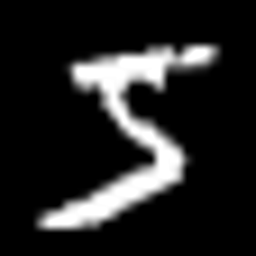

Image Size: (28, 28)
Digit is labelled: 5


In [5]:
mnist_dataset[0]["image"].resize((256, 256)).show()
print("Image Size:", mnist_dataset[0]["image"].size)
print("Digit is labelled:", mnist_dataset[0]['label'])

### Data Preprocessing and Augmentation

As downloaded, the MNIST dataset contains 60,000 PIL images with pixel values in the range of $[0,255]$. The data must be scaled, (potentially) resized, and turned into a tensor for ingestion by a PyTorch model. These transformations can be handled by torchvision's transforms library. Transform objects can be sequentially listed in a Compose constructor, which will apply then apply the transformations when an image is passed as an argument,

In [6]:
def transform(dataset):
    preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(
                (config.image_size, config.image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: 2*(x-0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}

In [7]:
mnist_dataset.reset_format()
mnist_dataset.set_transform(transform)

Once the dataset has been prepared with the proper transformers, it is ready to be passed directly into a PyTorch DataLoader.

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)

## Creating the Diffusion Model

### U-Net for MNIST

In [9]:
model = diffusers.UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [10]:
sample_image = mnist_dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 32, 32])


In [11]:
print('Output shape:', model(sample_image, timestep=0)["sample"].shape)

Output shape: torch.Size([1, 1, 32, 32])


### Noise Scheduler

In [12]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200, tensor_format='pt')

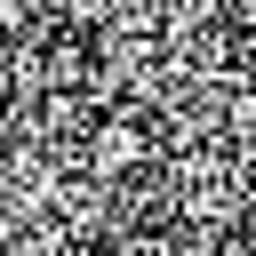

In [13]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([199])
noisy_image = noise_scheduler.add_noise(sample_image,noise,timesteps)

torchvision.transforms.ToPILImage()(noisy_image.squeeze(1)).resize((256,256))

### Optimizer

In [14]:
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)

### Learning Rate Scheduler

In [15]:
# Cosine learning rate scheduler

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps,
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

## Training the Model

### Hugging Face Accelerator

### Working with memory restrictions

In [16]:
torch.cuda.set_per_process_memory_fraction(7./8., 0)

### Creating and Running Training Loop

In [17]:
def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            batch_size = clean_images.shape[0]

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device)
            
            noisy_images=noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images,timesteps)["sample"]
                loss = torch.nn.functional.mse_loss(noise_pred,noise)
                accelerator.backward(loss)
                
                accelerator.clip_grad_norm_(model.parameters(),1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)
    
    accelerator.unwrap_model(model)

In [18]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [19]:
pipeline = diffusers.DDPMPipeline(unet=model,scheduler=noise_scheduler)

## Create a sampling function

In [20]:
@torch.no_grad()
def sample(unet, scheduler):
    scheduler.set_timesteps(1000)
    image=torch.randn((1,1,32,32)).to(model.device)
    
    
    for t in noise_scheduler.timesteps:
        model_output=unet(image,t)['sample']
        image=scheduler.step(model_output,int(t),image,generator=None)['prev_sample']
        
    return torchvision.transforms.ToPILImage()(image.squeeze(0))

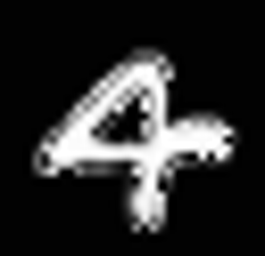

In [21]:
test_image=sample(model,noise_scheduler)
test_image.resize((265,256))

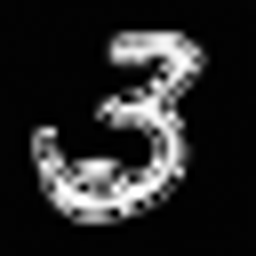

In [30]:
torch.manual_seed(1)
test_image=sample(model,noise_scheduler)
test_image.resize((256,256))

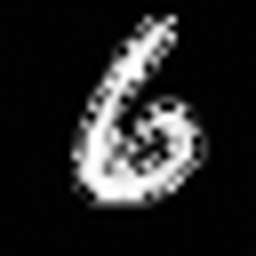

In [34]:
torch.manual_seed(5)
test_image=sample(model,noise_scheduler)
test_image.resize((256,256))